In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

2024-05-12 22:28:14.343145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 22:28:15.399638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-12 22:28:15.399796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-05-12 22:28:15.399811: W tensorflow/compiler/tf

In [27]:
dataframe = pd.read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# dataframe = pd.read_csv('/home/sam/Documents/projects/practice/tme_series/data/single_bill.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

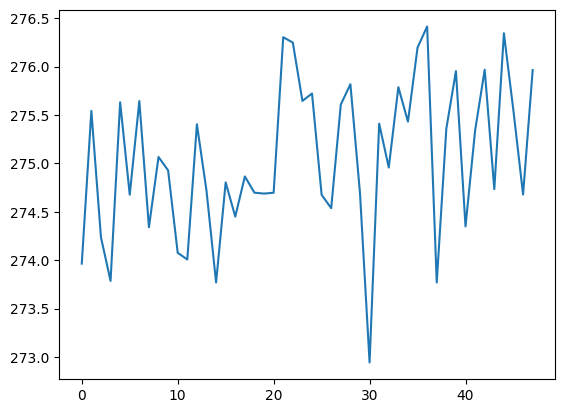

In [28]:
plt.plot(dataset)
plt.show()

In [29]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [30]:

# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]
print(len(train), len(test))

45 3


In [31]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [32]:

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [33]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back))
testX = np.reshape(testX, (testX.shape[0], look_back))

In [34]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
43/43 - 1s - loss: 0.3245 - 1s/epoch - 23ms/step
Epoch 2/100
43/43 - 0s - loss: 0.2445 - 44ms/epoch - 1ms/step
Epoch 3/100
43/43 - 0s - loss: 0.1784 - 62ms/epoch - 1ms/step
Epoch 4/100
43/43 - 0s - loss: 0.1282 - 51ms/epoch - 1ms/step
Epoch 5/100
43/43 - 0s - loss: 0.0934 - 68ms/epoch - 2ms/step
Epoch 6/100
43/43 - 0s - loss: 0.0730 - 65ms/epoch - 2ms/step
Epoch 7/100
43/43 - 0s - loss: 0.0617 - 69ms/epoch - 2ms/step
Epoch 8/100
43/43 - 0s - loss: 0.0568 - 77ms/epoch - 2ms/step
Epoch 9/100
43/43 - 0s - loss: 0.0549 - 72ms/epoch - 2ms/step
Epoch 10/100
43/43 - 0s - loss: 0.0543 - 72ms/epoch - 2ms/step
Epoch 11/100
43/43 - 0s - loss: 0.0541 - 74ms/epoch - 2ms/step
Epoch 12/100
43/43 - 0s - loss: 0.0539 - 72ms/epoch - 2ms/step
Epoch 13/100
43/43 - 0s - loss: 0.0540 - 74ms/epoch - 2ms/step
Epoch 14/100
43/43 - 0s - loss: 0.0536 - 74ms/epoch - 2ms/step
Epoch 15/100
43/43 - 0s - loss: 0.0536 - 69ms/epoch - 2ms/step
Epoch 16/100
43/43 - 0s - loss: 0.0535 - 74ms/epoch - 2ms/step
Ep

In [36]:
testX

array([[[0.74790955]]], dtype=float32)

In [37]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 11ms/step
Train Score: 0.78 RMSE
Test Score: 0.43 RMSE


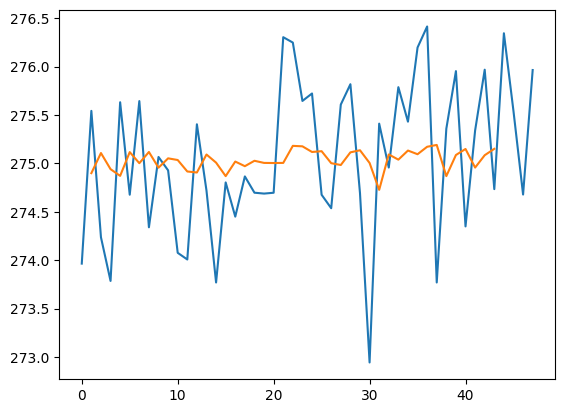

In [38]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
 # make prediction
 predictions.append(history[-1])
 # observation
 history.append(test[i])

In [40]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 0.290


In [42]:
dataframe = pd.read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')
# dataframe = pd.read_csv('/home/sam/Documents/projects/practice/tme_series/data/single_bill.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

/home/sam/Documents/projects/practice/fastapi/fastapi/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=275.415816, Expected=276.415257
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=275.778601, Expected=273.769391
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=273.011381, Expected=275.359094
1/1 [==============================] - 0s 12ms/step
Month=4, Predicted=274.820373, Expected=275.953838
1/1 [==============================] - 0s 12ms/step
Month=5, Predicted=274.499646, Expected=274.348854
1/1 [==============================] - 0s 11ms/step
Month=6, Predicted=274.741989, Expected=275.340214
1/1 [==============================] - 0s 13ms/step
Month=7, Predicted=274.352782, Expected=275.968519
1/1 [==============================] - 0s 12ms/step
Month=8, Predicted=274.525812, Expected=274.734269
1/1 [==============================] - 0s 12ms/step
Month=9, Predicted=275.297683, Expected=276.345214
1/1 [==============================] - 0s 13ms/step
Month=10, Predicted=2

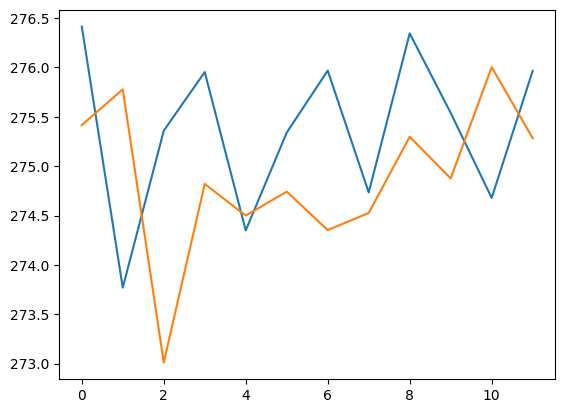

In [43]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('/home/sam/Documents/projects/practice/tme_series/data/clustring 1 average .csv', usecols=[1], engine='python')

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [22]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = pd.DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = pd.concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df

In [23]:
supervised = timeseries_to_supervised(dataset, 1)
print(supervised.head())

          0         0
0  0.000000  0.062752
1  0.062752  0.908561
2  0.908561  0.255939
3  0.255939  0.671000
4  0.671000  0.325863


In [26]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [27]:

# invert differenced value
def inverse_difference(history, yhat, interval=1):
 return yhat + history[-interval]

In [28]:
differenced = difference(dataset, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(dataset, differenced[i], len(dataset)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0     [0.8458091]
1    [-0.6526222]
2     [0.4150605]
3    [-0.3451367]
4    [0.29852086]
dtype: object
0     [0.9085612]
1      [0.255939]
2     [0.6709995]
3    [0.32586282]
4     [0.6243837]
dtype: object


In [31]:
# transform scale
X = differenced.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

In [32]:
inverted_X = scaler.inverse_transform(scaled_X)

In [33]:
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

0    0.845809
1   -0.652622
2    0.415060
3   -0.345137
4    0.298521
dtype: float64


In [35]:
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

In [ ]:
layer = LSTM(4, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True)

In [ ]:
for i in range(1500):
    model.fit(X, 4, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

In [34]:

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [36]:
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [37]:
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=0.533882, Expected=0.619901
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=0.584692, Expected=0.860152
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=0.770611, Expected=0.593456
1/1 [==============================] - 0s 16ms/step
Month=4, Predicted=0.872931, Expected=0.960556
1/1 [==============================] - 0s 12ms/step
Month=5, Predicted=0.822775, Expected=0.229493
1/1 [==============================] - 0s 14ms/step
Month=6, Predicted=0.735550, Expected=0.483640
1/1 [==============================] - 0s 13ms/step
Month=7, Predicted=0.527405, Expected=0.052891
1/1 [==============================] - 0s 13ms/step
Month=8, Predicted=0.244512, Expected=0.556701
1/1 [==============================] - 0s 13ms/step
Month=9, Predicted=0.290932, Expected=0.343792
1/1 [==============================] - 0s 12ms/step
Month=10, Predicted=0.284419, Expected=0.839982
1/1 [====

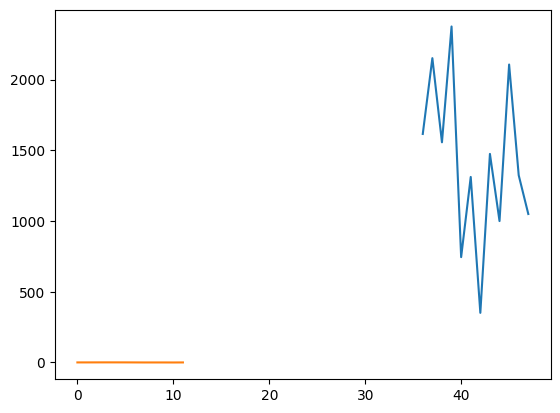

In [39]:
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
# raw_values = dataset.values
diff_values = difference(dataset, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # invert differencing
 yhat = inverse_difference(dataset, yhat, len(test_scaled)+1-i)
 # store forecast
 predictions.append(yhat)
 expected = dataset[len(train) + i + 1]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(dataset[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(dataframe[-12:])
pyplot.plot(predictions)
pyplot.show()
